In [2]:
## Installation
# pip install -r /sensei-fs/users/mrizve/projects/InternVideo/InternVideo2/multi_modality/requirements.txt
# git clone https://github.com/Dao-AILab/flash-attention
# cd flash-attention
# cd csrc/fused_dense_lib && pip install .
# cd ../..
# cd csrc/layer_norm && pip install .

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from multi_modality.models.backbones.internvideo2.internvideo2 import pretrain_internvideo2_1b_patch14_224
from omegaconf import OmegaConf

import logging
import pandas as pd
from tqdm.notebook import trange, tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/runai-home/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/runai-home/.local/lib/python3.10/site-packages/flash_attn/ops/fused_dense.py:27: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, x, weight, bias, return_residual=False, process_group=None,
/home/runai-home/.local/lib/python3.10/site-packages/flash_attn/ops/fused_dense.py:67: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output, *args):
/home/runai-home/.local/lib/python3.10/site-packages/flash_attn/ops/fused_dense.py:193: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `tor

[2024-11-01 17:36:40,371] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
cannot import name 'log' from 'torch.distributed.elastic.agent.server.api' (/home/runai-home/.local/lib/python3.10/site-packages/torch/distributed/elastic/agent/server/api.py)
deepspeed is not installed!!!


/home/runai-home/.local/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:49: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/runai-home/.local/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:67: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


In [ ]:
model_conf = dict(
            vision_encoder=dict(
                # backbone
                name="pretrain_internvideo2_1b_patch14_224",
                img_size=224, 
                num_frames=8,
                tubelet_size=1,
                patch_size=14, 
                d_model=1408,
                clip_embed_dim=768,
                clip_teacher_embed_dim=3200,
                clip_teacher_final_dim=768,
                clip_norm_type='l2',
                clip_return_layer=6,
                clip_student_return_interval=1,
                pretrained='/InternVideo2-Stage2_1B-224p-f4/InternVideo2-stage2_1b-224p-f4.pt',
                use_checkpoint=True,
                checkpoint_num=40,
                use_flash_attn=True,
                # use_flash_attn=False,
                use_fused_rmsnorm=True,
                use_fused_mlp=True,
                orig_t_size=4, #number of frames used to train the loaded checkpoint
                # clip teacher
                clip_teacher=None,
                clip_input_resolution=224,
                clip_teacher_return_interval=1,
                # mask
                video_mask_type="random",
                video_mask_ratio=0.8,
                image_mask_type="random",
                image_mask_ratio=0.5,
                sep_image_video_pos_embed=True,
                keep_temporal=False,
                only_mask=True
            ),
            embed_dim=512,
        )

In [ ]:
dataset_parquet = "generated_video_control_dataset.parquet"

model_conf = OmegaConf.create(model_conf)
model = pretrain_internvideo2_1b_patch14_224(model_conf)
# TODO: is this the distribution for the iv2 training data?
v_mean = np.array([0.485, 0.456, 0.406]).reshape(1,1,3)
v_std = np.array([0.229, 0.224, 0.225]).reshape(1,1,3)
device = 'cuda'

model = model.to(device)
model = model.cuda().to(dtype=torch.bfloat16).eval().requires_grad_(False)

logger = logging.getLogger(__name__)

Loading pretrained weights from /sensei-fs/users/mrizve/data/checkpoints/InternVideo2-Stage2_1B-224p-f4/InternVideo2-stage2_1b-224p-f4.pt


/sensei-fs/users/mrizve/projects/InternVideo/InternVideo2/multi_modality/models/backbones/internvideo2/internvideo2.py:720: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sta

Temporal interpolate from 4 to 8 (pos_embed)
Temporal interpolate from 4 to 8 (clip_pos_embed)
ckpt loaded <All keys matched successfully>


In [5]:
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    if 2 <= duration <= 30:
        # Extract all frames for videos between 2 and 30 seconds
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()
        return frames
    elif 30 < duration < 60:
        # Extract frames from the middle 30 seconds
        start_frame = int((total_frames - 30 * fps) / 2)
        end_frame = start_frame + int(30 * fps)
        
        frames = []
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) > end_frame:
                break
            frames.append(frame)
        cap.release()
        return frames
    else:
        cap.release()
        logger.warning(f"Video duration is not between 2 and 60 seconds: {duration}")
        return None


def frames2tensor(vid_list, fnum=8, target_size=(224, 224)):
    assert(len(vid_list) >= fnum) #1200 // 16 = 75
    step = len(vid_list) // fnum
    vid_list = vid_list[::step][:fnum]
    vid_list = [cv2.resize(x[:,:,::-1], target_size) for x in vid_list]
    vid_tube = [np.expand_dims(normalize(x), axis=(0, 1)) for x in vid_list]
    vid_tube = np.concatenate(vid_tube, axis=1)
    vid_tube = np.transpose(vid_tube, (0, 1, 4, 2, 3))
    vid_tube = torch.from_numpy(vid_tube).to(device, non_blocking=True).float()
    return vid_tube
    
def normalize(data):
    return (data/255.0-v_mean)/v_std

def get_vid_feat(frames, num_frames=16, size_t=224):
    if isinstance(frames, list):
        frames_tensor = frames2tensor(frames, fnum=num_frames, target_size=(size_t, size_t))
        frames_tensor = frames_tensor.permute(0, 2, 1, 3, 4) # [B,T,C,H,W] -> [B,C,T,H,W]

    else:
        frames_tensor = frames
    with torch.no_grad():
        vision_embeds, pooled_vision_embeds, _, _ = model(frames_tensor, None)
        vfeat = model.vision_proj(pooled_vision_embeds)
        return torch.cat([vfeat, pooled_vision_embeds], dim=-1)

In [20]:
# read the dataset parquet to get video paths
df = pd.read_parquet(dataset_parquet)
df.head()

# get the video paths
video_paths = df['video_path'].tolist()
onehot_labels = torch.tensor(df['onehot'].tolist()).to(device)
video_tags = df['tags'].tolist()

# find the unique base_caption
base_captions = df['base_caption'].unique()
print(f"Number of unique base captions: {len(base_captions)}")

# generate the classificaiton GT based on the unique base_caption
# caption_gt = []

Number of unique base captions: 400


In [21]:
df.head()

cid                                       base_caption  \
0  352861543  Thoughtful African man thinking and working in...   
1  352861543  Thoughtful African man thinking and working in...   
2  352861543  Thoughtful African man thinking and working in...   
3  352861543  Thoughtful African man thinking and working in...   
4  352861543  Thoughtful African man thinking and working in...   

                                   augmented_caption  augmented  \
0  Thoughtful African man thinking and working in...          0   
1  Thoughtful African man thinking and working in...          1   
2  Thoughtful African man thinking and working in...          1   
3  Thoughtful African man thinking and working in...          1   
4  Thoughtful African man thinking and working in...          1   

                                          video_path  \
0  /sensei-fs/users/chengyuanx/projects/internv2/...   
1  /sensei-fs/users/chengyuanx/projects/internv2/...   
2  /sensei-fs/users/chengyuanx/projects/internv2/...   
3  /sensei-fs/users/chengyuanx/projects/internv2/...   
4  /sensei-fs/users/chengyuanx/projects/internv2/...   

                                              onehot                   tags  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                     []  
1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   [ & camera pan left]  
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [ & camera pan right]  
3  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    [ & camera zoom in]  
4  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   [ & camera zoom out]

In [22]:
# # calcute the iv2 feature for each video
# iv2_features_cls = []

# id = 0
# for video_path in tqdm(video_paths):
#     frames = extract_frames(video_path)
#     vid_feat = get_vid_feat(extract_frames(video_path), num_frames=model_conf.vision_encoder.num_frames)
#     iv2_features_cls.append(vid_feat)

#     # save feature to file in case it crashes
#     if id % 1000 == 0:
#         torch.save(torch.stack(iv2_features_cls), f"iv2_features_cls_first_{id}_rows.pt")
#     id += 1

# torch.save(torch.stack(iv2_features_cls), f"iv2_features_cls_full.pt")

In [ ]:
iv2_feat_pt = "iv2_features_cls_full_22800.pt"
iv2_features = torch.load(iv2_feat_pt)
iv2_features = iv2_features.squeeze()
print(iv2_features.shape)
print(onehot_labels.shape)

assert iv2_features.shape[0] == onehot_labels.shape[0]

# get some stats about the features
print(torch.mean(iv2_features))
print(torch.std(iv2_features))

torch.Size([22800, 1280])
torch.Size([22800, 37])
tensor(0.0225, device='cuda:0', dtype=torch.bfloat16)
tensor(2.3281, device='cuda:0', dtype=torch.bfloat16)


/tmp/ipykernel_1023432/2697358052.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  iv2_features = torch.load(iv2_feat_pt)


In [24]:
# create a MLP to train a classifier to predict the onehot labels
class iv2_MLP(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(iv2_MLP, self).__init__()
        
        self.fc1 = torch.nn.Linear(in_features, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.fc2 = torch.nn.Linear(512, 512)
        self.bn2 = torch.nn.BatchNorm1d(512)
        self.fc3 = torch.nn.Linear(512, out_features)
        
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)  # Reduced dropout rate

        # Initialize weights for better training stability
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)  # Output logits; softmax is applied in loss function
        return x


In [25]:
# camera motion tags
camera_motion_tags = [
    " & camera pan left",
    " & camera pan right",
    " & camera zoom in",
    " & camera zoom out",
    " & camera tilt up",
    " & camera tilt down",
    " & camera locked down",
    " & camera handheld"
]

camera_shotsize_tags = [
    " & close-up shot",
    " & extreme close-up",
    " & medium shot",
    " & long shot",
    " & extreme long shot"
]

camera_angle_tags = [
    " & aerial shot",
    " & eye_level shot",
    " & high angle shot",
    " & low angle shot",
    " & top-down shot",
]

video_motion_speed_tags = [
    "slow motion",
    "fast motion",
    "stop motion",
    "camera rotation",
]

color_style_tags = [
    "line art",
    "watercolor",
    "2D animation",
    "3D animation",
    "claymation",
    "oil painting",
    "anime",
    "pixel art",
    "gray scale",
    "bokeh effect",
    "layered paper",
    "simple shapes",
    "sketch",
    "hyper realistic",
    "vector art",
]

all_class_tags = ["no_style"] + camera_motion_tags + camera_shotsize_tags + camera_angle_tags + video_motion_speed_tags + color_style_tags

In [26]:
print(onehot_labels.shape)
# the onehot_labels are [1, 36] but I actually have 37 classes
# so adding an additional dimension at the beginning to represent the all-zero "no_style" class
onehot_labels_extend = torch.cat([torch.zeros(onehot_labels.shape[0], 1).to(device), onehot_labels], dim=1)
print(onehot_labels_extend.shape)

# the index of all rows that are not augmented, "augmented" column is 0
base_caption_idx = df[df['augmented'] == 0].index

# change vectors of base_caption_idx to a 1 in the first position
onehot_labels_extend[base_caption_idx, 0] = 1

onehot_labels = onehot_labels_extend

torch.Size([22800, 37])
torch.Size([22800, 38])


In [27]:
onehot_labels[:3]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0')

In [28]:
# every value in base_caption_idx should be divisible by 57
assert all([x % 57 == 0 for x in base_caption_idx])

print(base_caption_idx)

Index([    0,    57,   114,   171,   228,   285,   342,   399,   456,   513,
       ...
       22230, 22287, 22344, 22401, 22458, 22515, 22572, 22629, 22686, 22743],
      dtype='int64', length=400)


In [29]:
iv2_features_cat = []

# re-construct the feature vectors by concatenating every vector from base_caption_idx to each following 56 vectors
for i in range(len(iv2_features)):
    if i in base_caption_idx:
        curr_base_feat = iv2_features[i]
    iv2_features_cat.append(torch.cat([curr_base_feat, iv2_features[i]], dim=0))

iv2_features_cat = torch.stack(iv2_features_cat)

In [30]:
print(iv2_features_cat.shape)
iv2_features = iv2_features_cat

torch.Size([22800, 2560])


train samples: 15959, test samples: 6841


Epoch 1/50, Train Loss: 0.2130, Test Loss: 0.1289, Test Accuracy: 0.1905
best accuracy so far, saved model at epoch 1
Epoch 2/50, Train Loss: 0.1219, Test Loss: 0.1131, Test Accuracy: 0.2602
best accuracy so far, saved model at epoch 2
Epoch 3/50, Train Loss: 0.1086, Test Loss: 0.1044, Test Accuracy: 0.2940
best accuracy so far, saved model at epoch 3
Epoch 4/50, Train Loss: 0.1002, Test Loss: 0.0997, Test Accuracy: 0.3160
best accuracy so far, saved model at epoch 4
Epoch 5/50, Train Loss: 0.0947, Test Loss: 0.0961, Test Accuracy: 0.3273
best accuracy so far, saved model at epoch 5
Epoch 6/50, Train Loss: 0.0906, Test Loss: 0.0942, Test Accuracy: 0.3364
best accuracy so far, saved model at epoch 6
Epoch 7/50, Train Loss: 0.0871, Test Loss: 0.0924, Test Accuracy: 0.3492
best accuracy so far, saved model at epoch 7
Epoch 8/50, Train Loss: 0.0840, Test Loss: 0.0911, Test Accuracy: 0.3530
best accuracy so far, saved model at epoch 8
Epoch 9/50, Train Loss: 0.0820, Test Loss: 0.0899, Test 

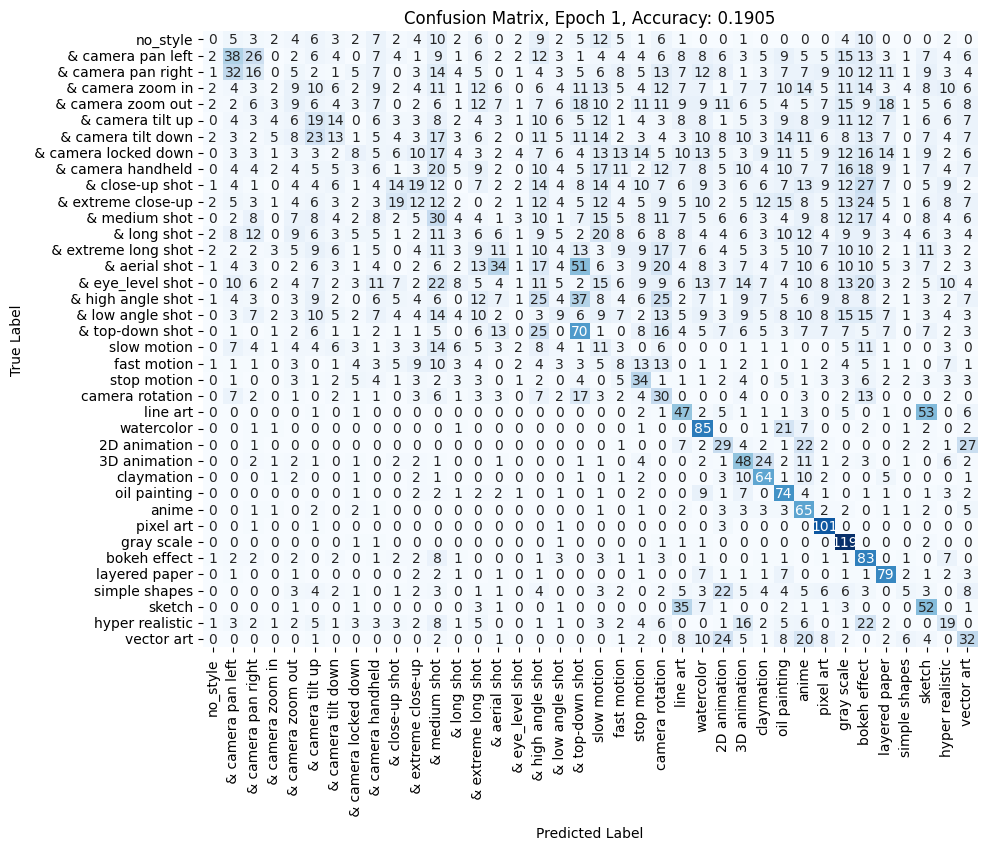

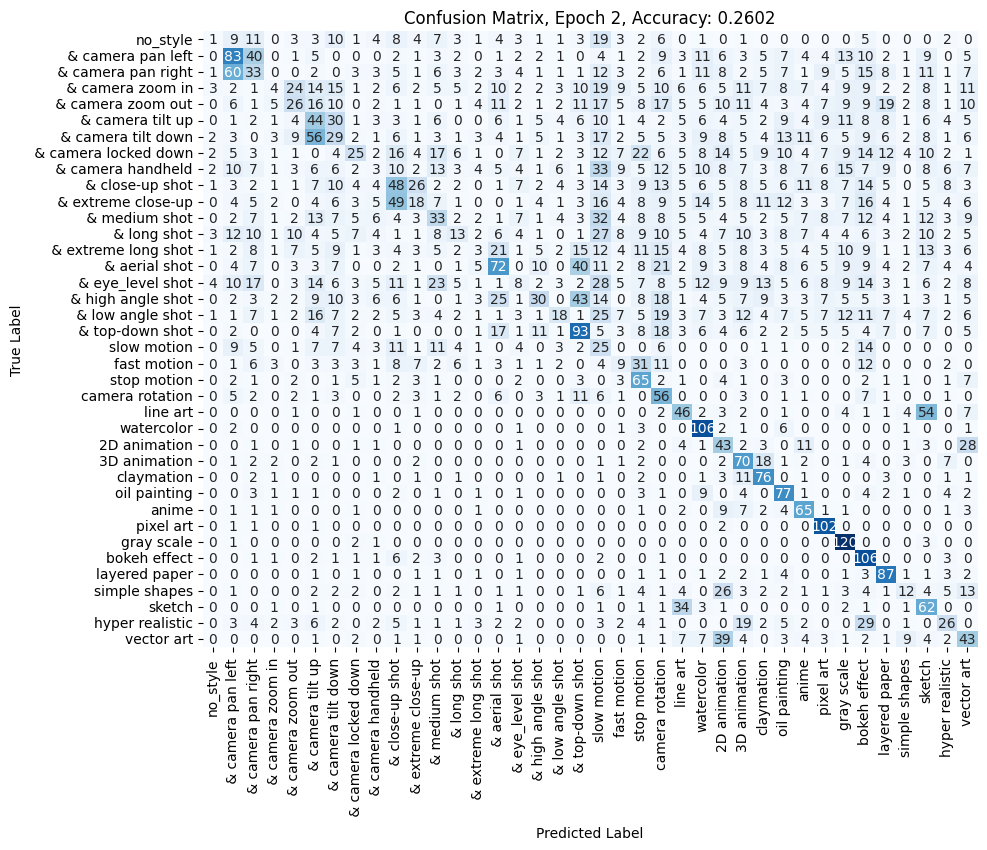

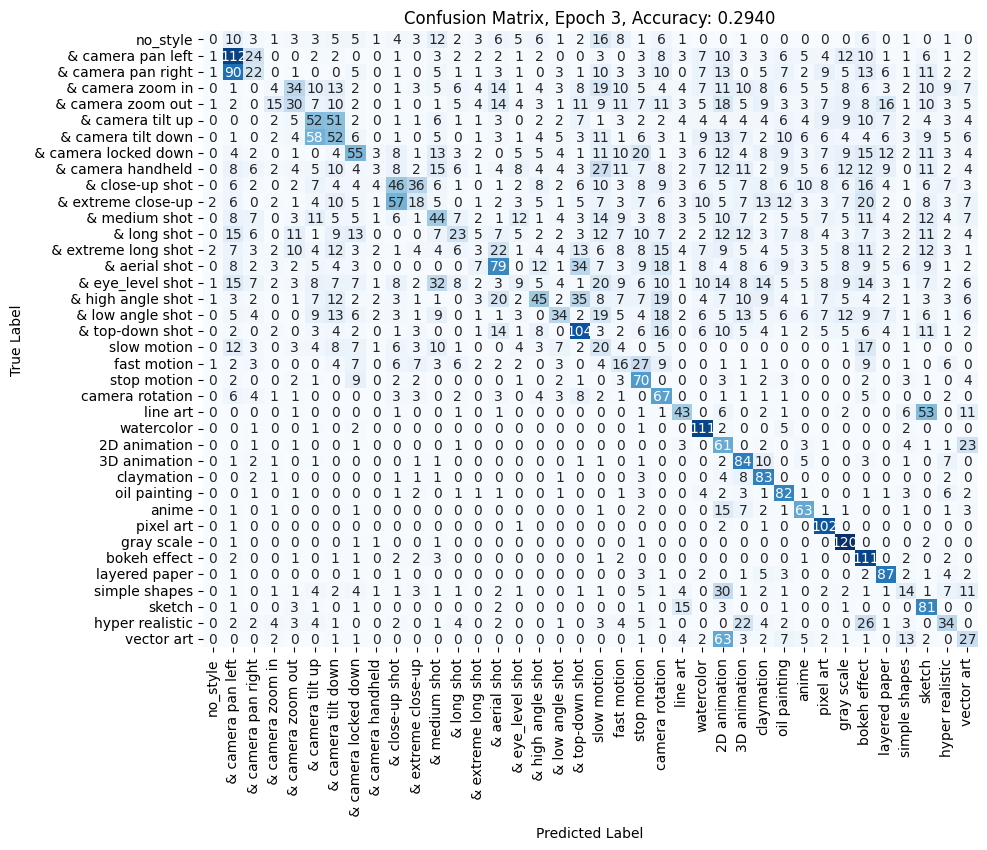

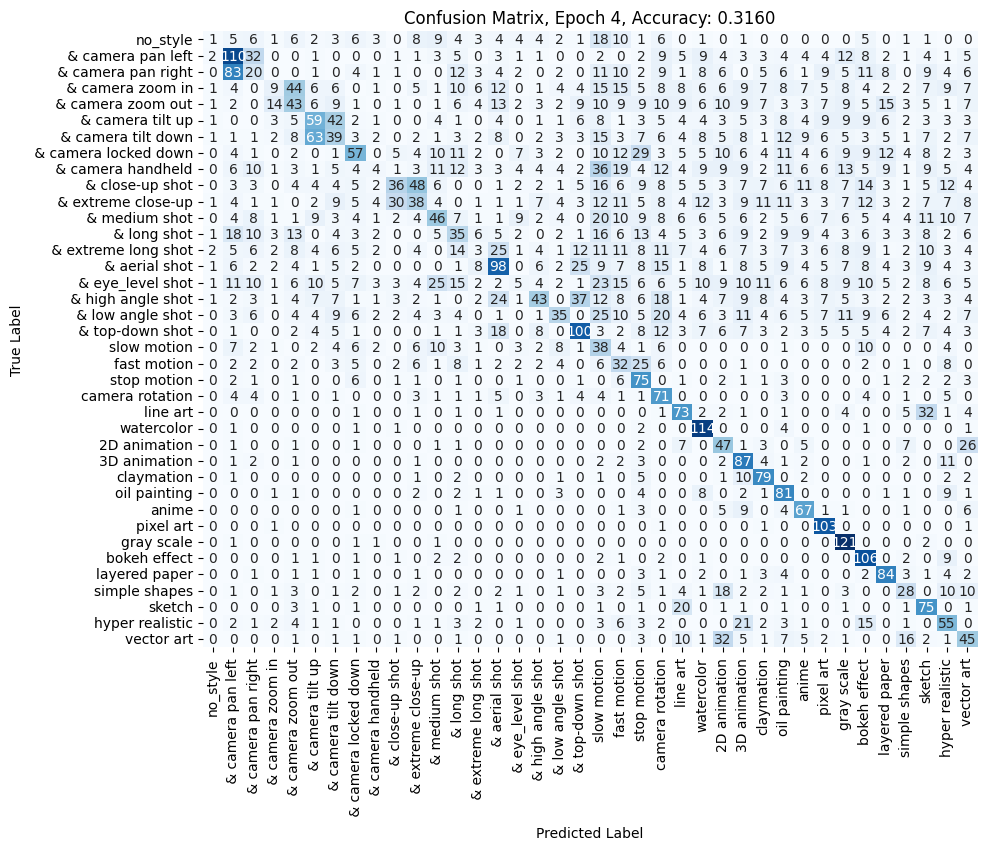

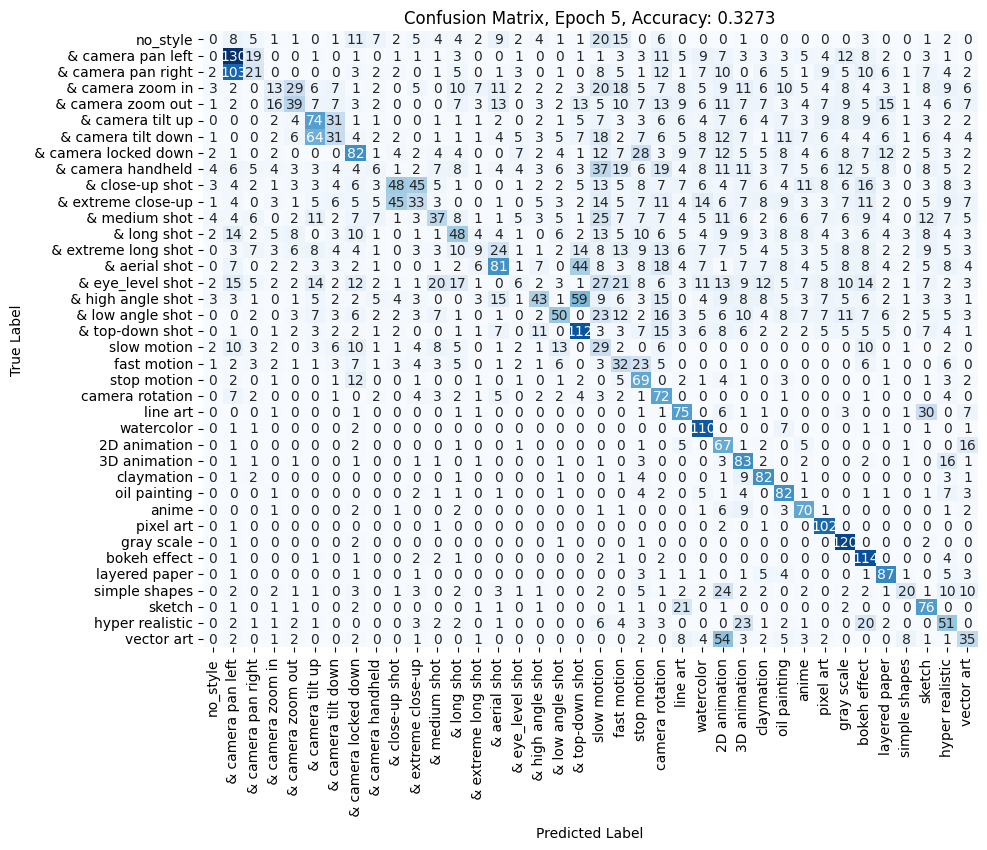

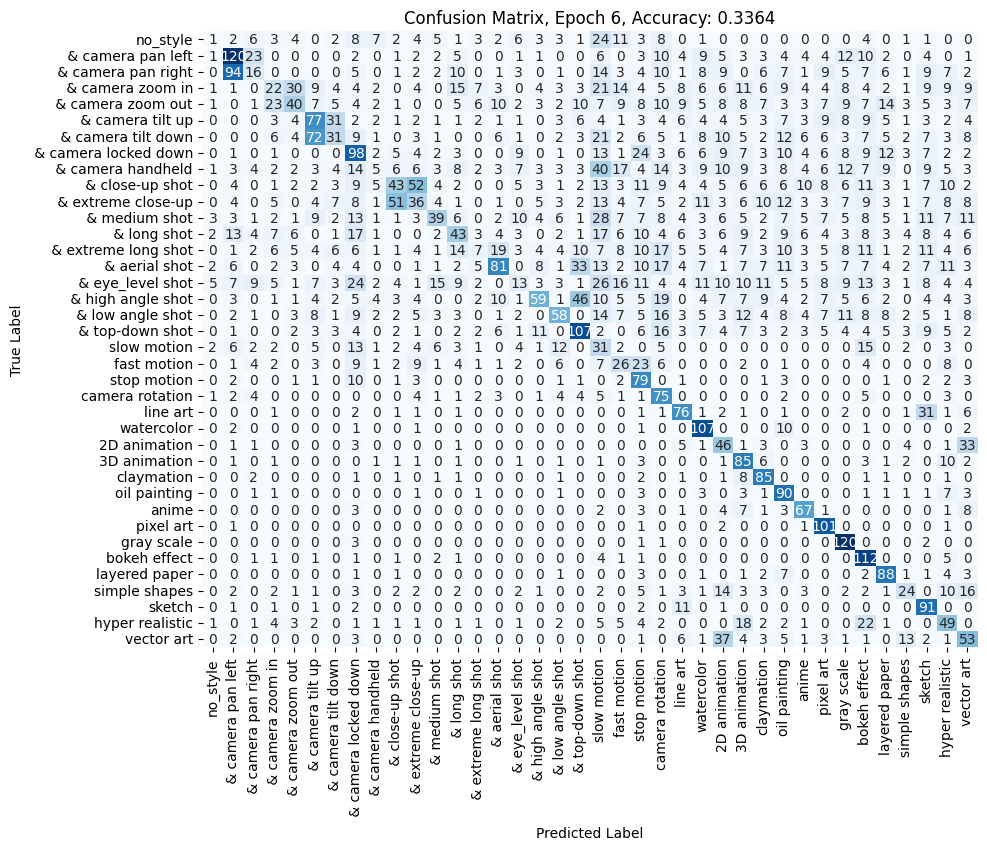

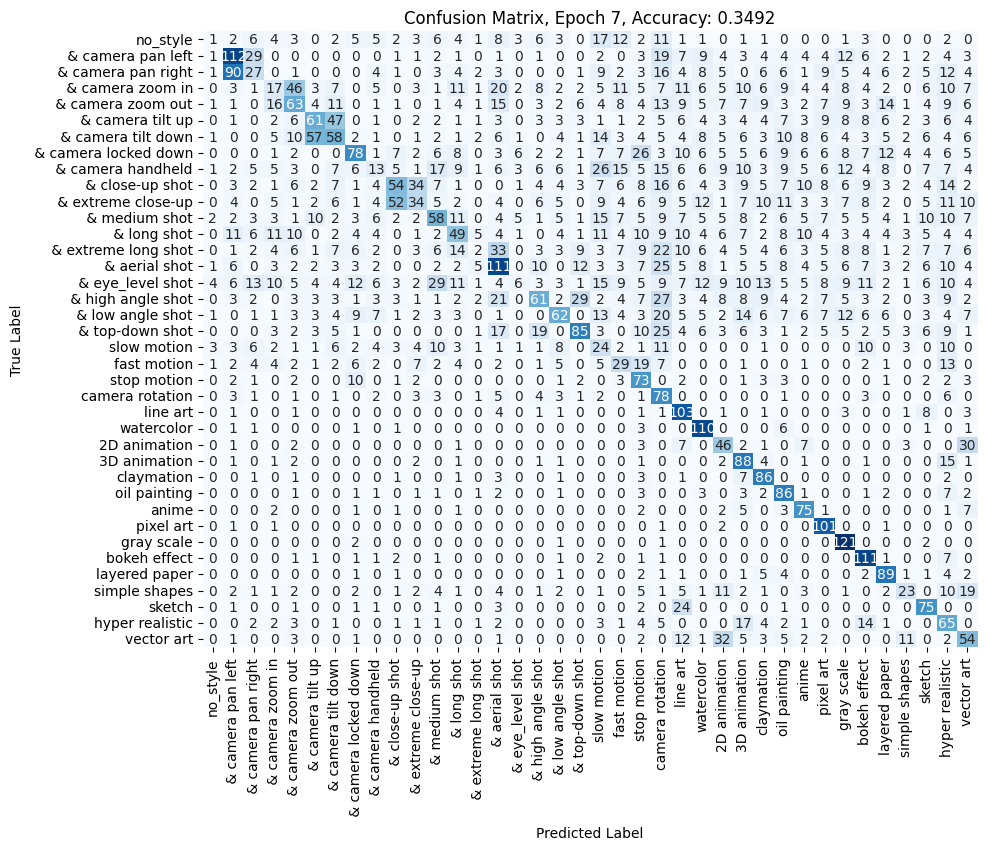

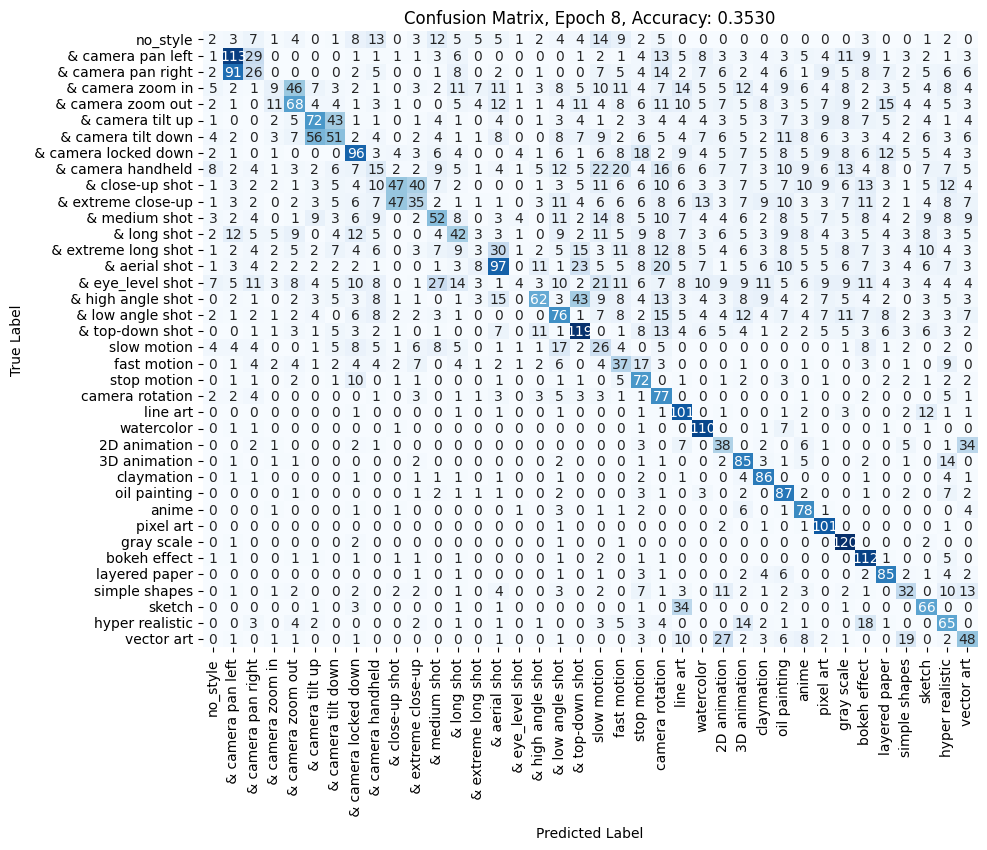

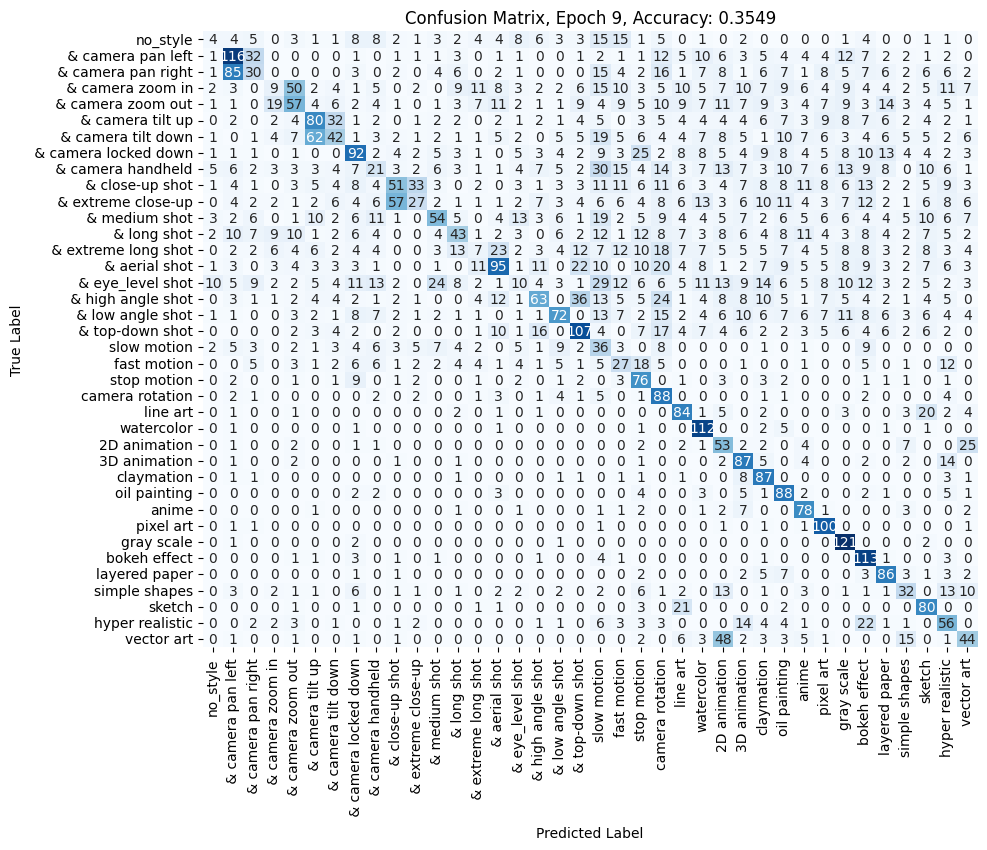

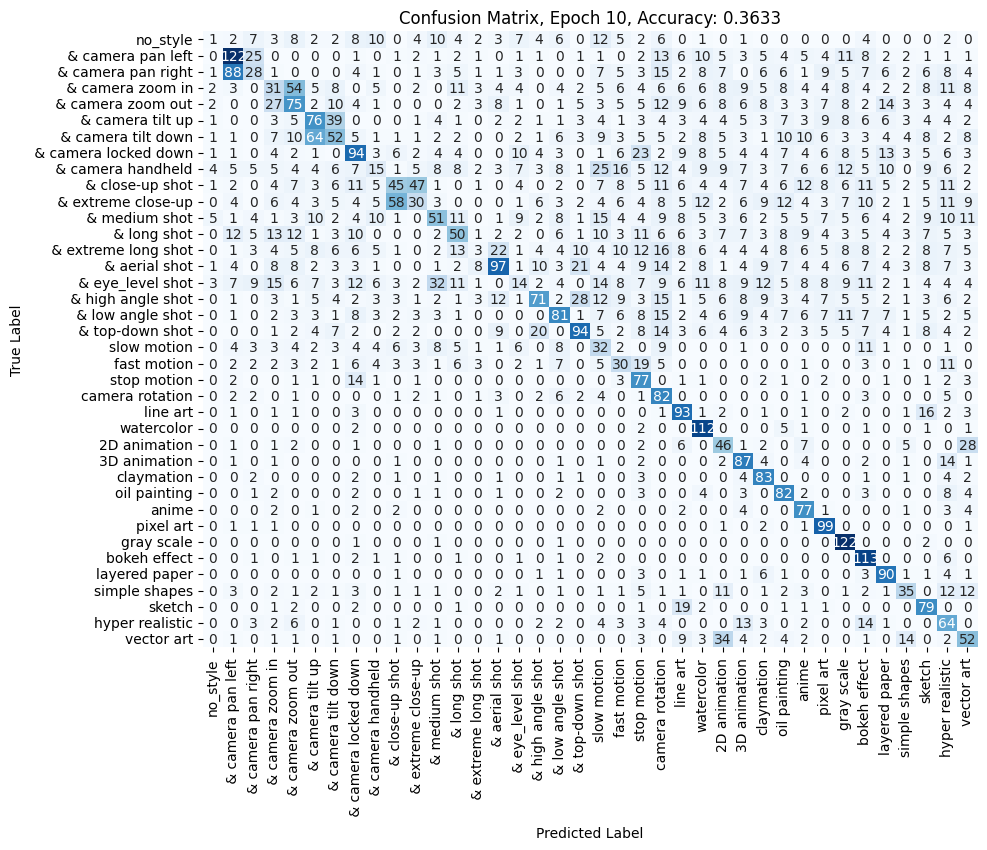

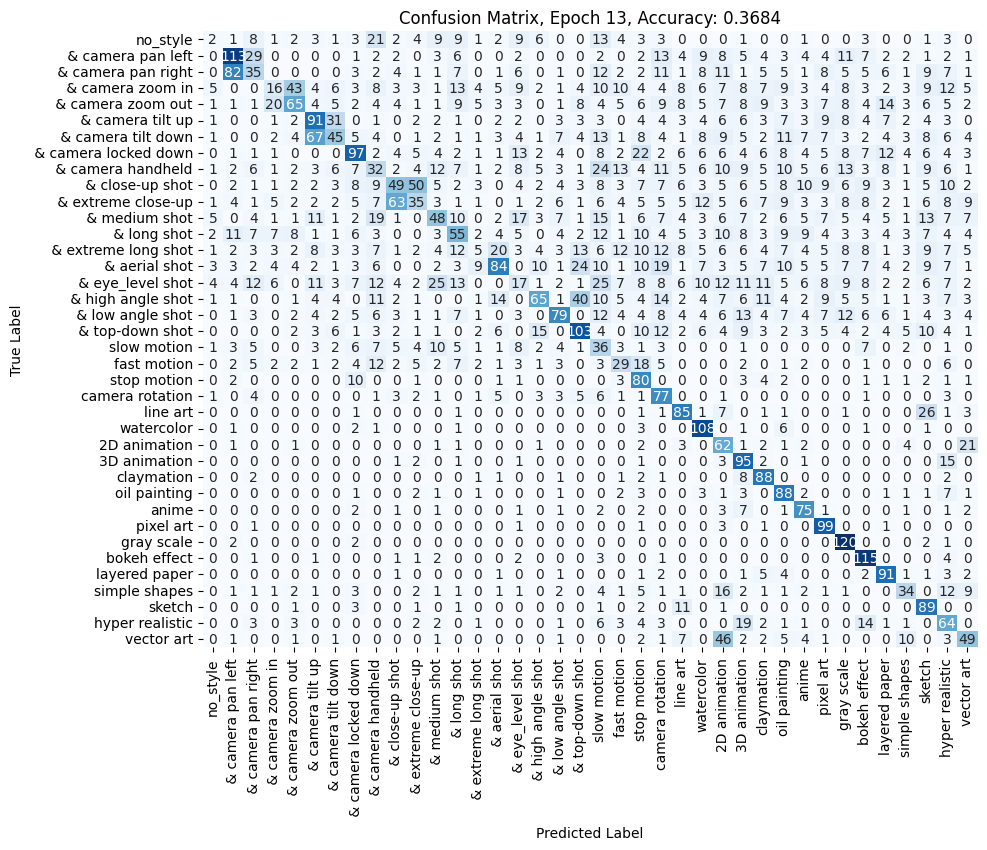

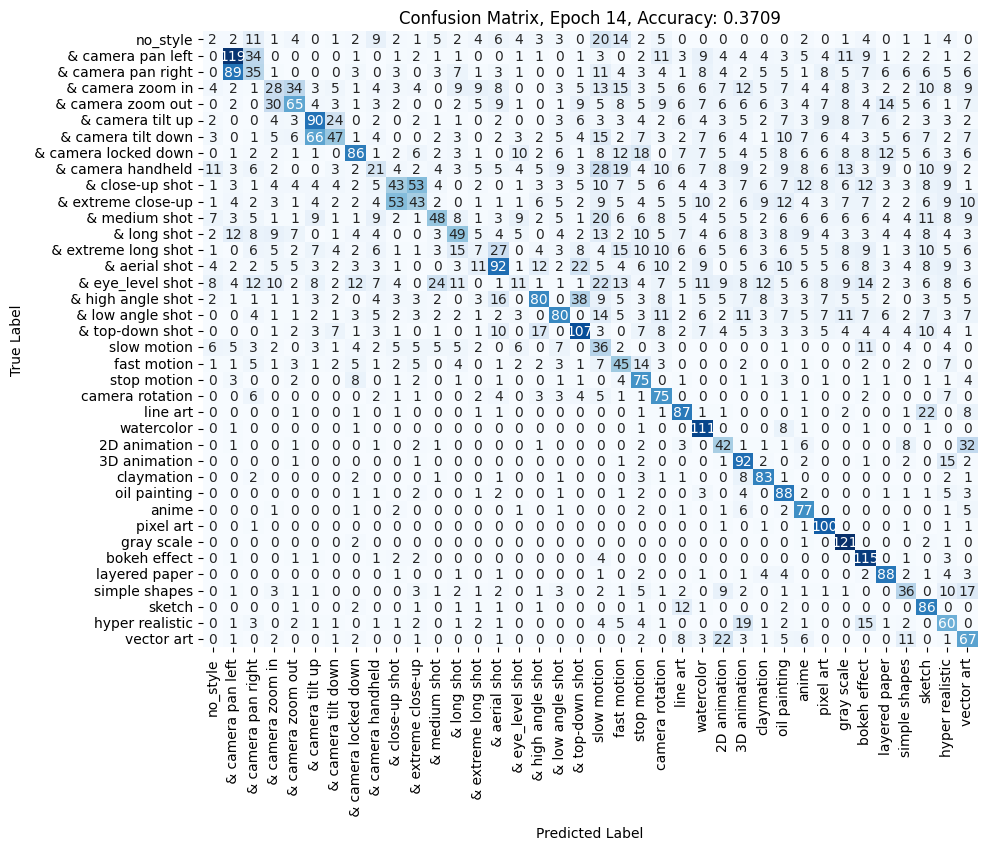

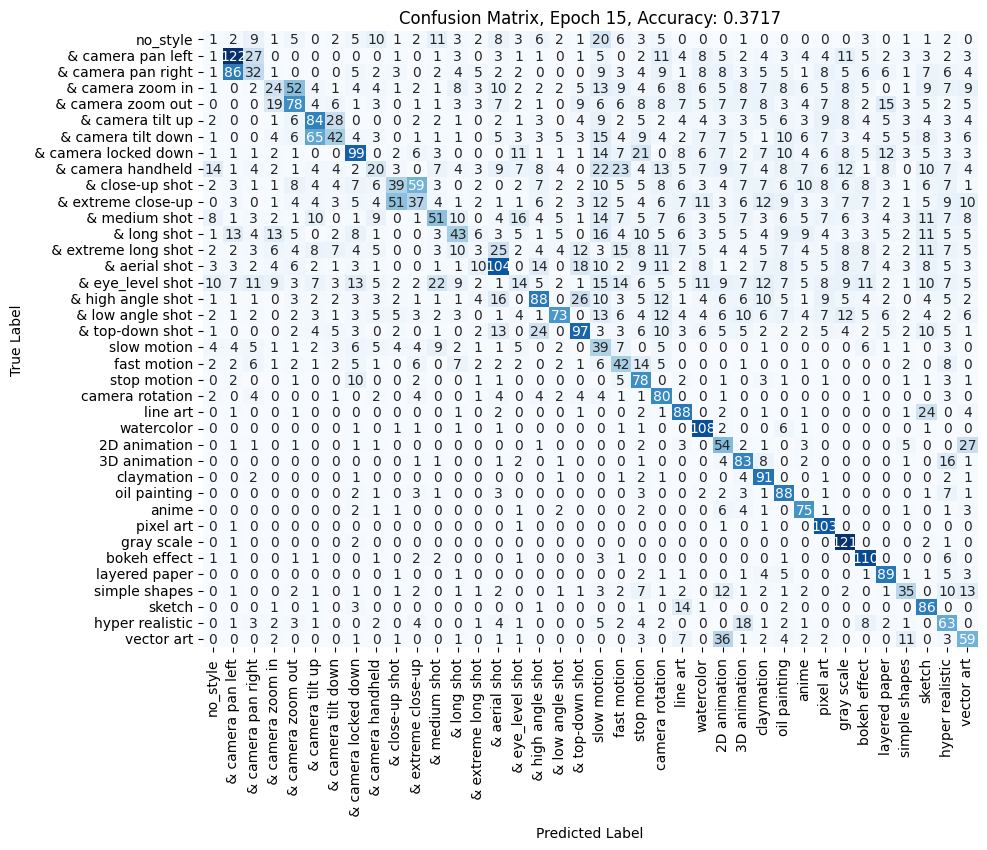

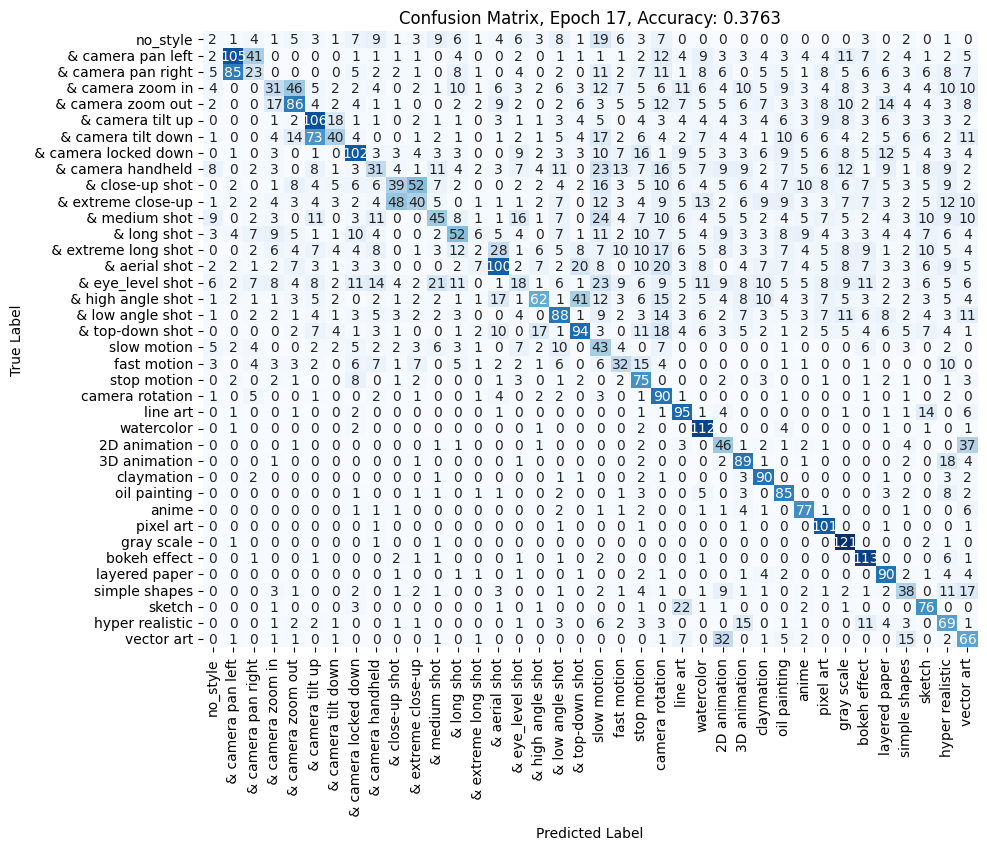

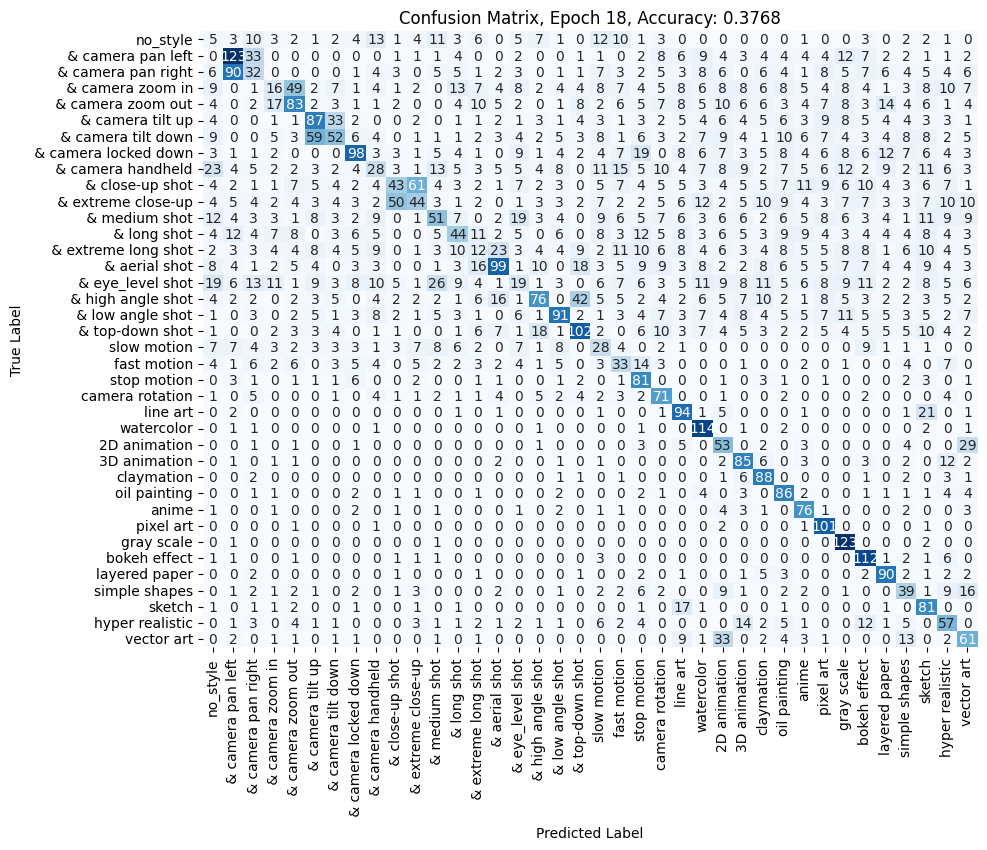

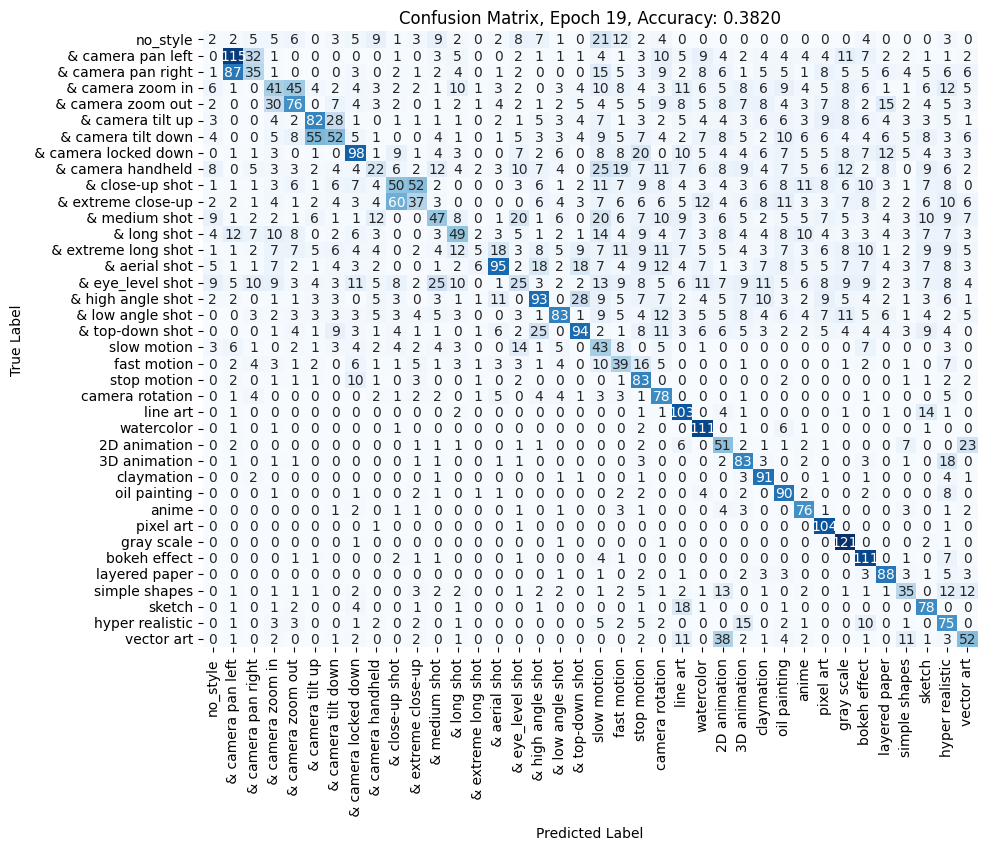

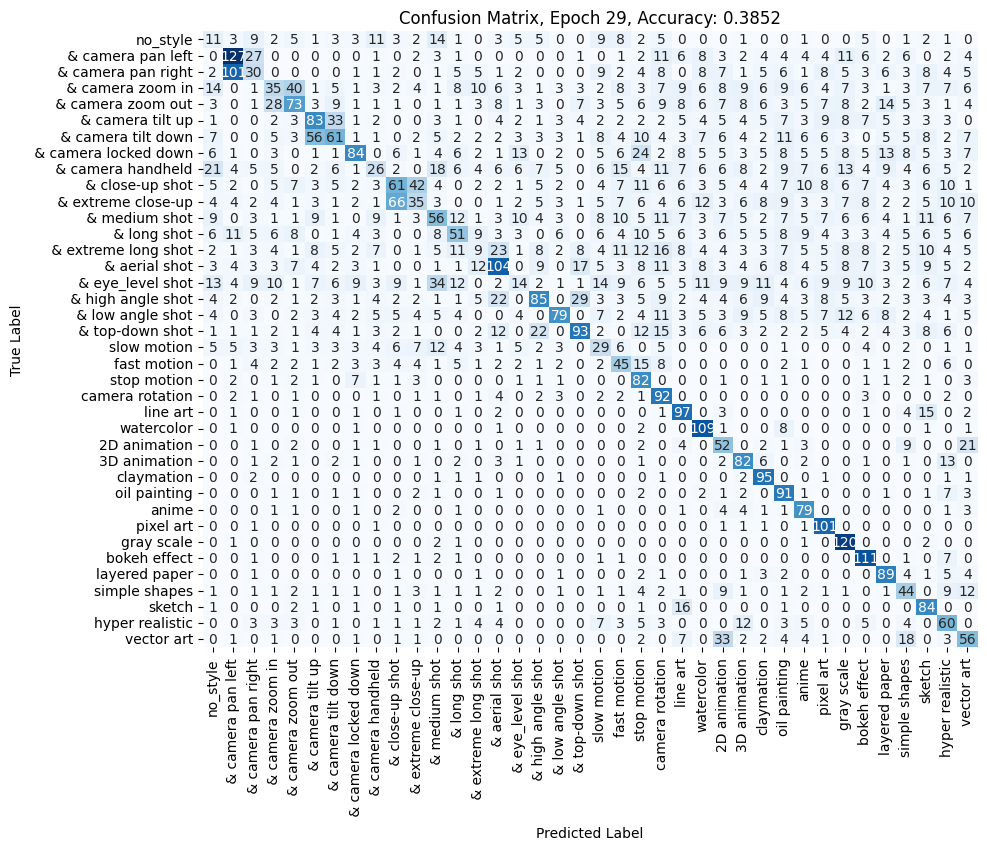

In [31]:
in_features = iv2_features.shape[-1]
num_classes = onehot_labels.shape[-1] # add one for no_style

out_dir = "iv2_36cls_classifier"
os.makedirs(out_dir, exist_ok=True)

# use float32
dtype = torch.float32

model = iv2_MLP(in_features=in_features, out_features=num_classes)
model = model.to(device).to(dtype=dtype).train().requires_grad_(True)

# randomly shuffle the data and split into train and test
indices = torch.randperm(iv2_features.shape[0])
iv2_features = iv2_features[indices]
onehot_labels = onehot_labels[indices]

train_size = int(0.7 * iv2_features.shape[0])
train_features = iv2_features[:train_size]
train_labels = onehot_labels[:train_size]
test_features = iv2_features[train_size:]
test_labels = onehot_labels[train_size:]

print(f"train samples: {train_features.shape[0]}, test samples: {test_features.shape[0]}")

# simple dataloader
class DataLoader(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Train the model
num_epochs = 50
batch_size = 128
best_accuracy = 0.0

train_loader = torch.utils.data.DataLoader(DataLoader(train_features, train_labels), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(DataLoader(test_features, test_labels), batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for features, labels in train_loader:
        features = features.to(device).to(dtype=dtype)
        labels = labels.to(device).to(dtype=dtype)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Set the model to evaluation mode
    model.eval()
    test_loss = 0
    y_true = []
    y_pred = []

    # Disable gradient computation for faster evaluation
    with torch.no_grad():
        for features, labels in test_loader:
            # Move data to the appropriate device and dtype
            features = features.to(device).to(dtype=dtype)
            labels = labels.to(device).to(dtype=dtype)
            
            # Forward pass to get outputs
            outputs = model(features)
            
            # Compute the loss and accumulate it
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        
            # Convert one-hot encoded labels to integer class labels
            y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())
            
            # Convert model outputs to predicted class labels
            predicted_labels = torch.argmax(outputs, dim=1)
            y_pred.extend(predicted_labels.cpu().numpy())

    # Calculate the average test loss
    test_loss /= len(test_loader)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    # print("Confusion Matrix:\n", conf_matrix)

    # compute the accuracy
    accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # save model and plot if new best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), f"iv2_36cls_classifier/iv2_mlp_best_epoch{epoch+1}.pt")
        print(f"best accuracy so far, saved model at epoch {epoch+1}")

        # Plot the confusion matrix with Seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=all_class_tags, yticklabels=all_class_tags)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix, Epoch {epoch + 1}, Accuracy: {accuracy:.4f}')
        # save the confusion matrix as images
        plt.savefig(f"iv2_36cls_classifier/iv2_mlp_epoch_{epoch + 1}_confusion_matrix.png")
